#CI Project - NLP
---
##LSTM Models

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from keras.utils import to_categorical

## Loading Dataset
---

In [3]:
data = pd.read_csv("sentiment.csv")
# data = data[data.sentiment_confidence > 0.5]

In [4]:
classes = ["Negative", "Neutral", "Positive"]

text = data['text']
labels = data['sentiment']

In [8]:
#test_data = pd.read_csv('FIFA22.csv')[:20]
test_data=pd.read_csv("TedCruz23.csv")
test_text = test_data['tweet']
test_label = test_data['label']

In [9]:
test_data['tweet']

0     @NN4594 @WalpurgaMueller @tedcruz It IS a priv...
1                             @tedcruz Ted is confused.
2                                      @tedcruz AMERICA
3     @tedcruz @JohnCornyn @TXRandy14   "the deadlie...
4                            @ericareport Like Ted Cruz
5     @tedcruz Its not being a Small Town Mayor, its...
6     @tedcruz It’s almost like a weasel that tries ...
7     @svoboda_pamela @oheardintherapy @tedcruz That...
8     @Suarez1Pro1977 @tedcruz Ted Cruz really has t...
9     @DonaldJTrumpJr ** More importantly **  Was Jo...
10    @tedcruz @GregAbbott_TX  WHY have you done not...
11                    @tedcruz  https://t.co/BjGnxi5RBw
12    @tedcruz Ah haha haha haha no one is concerned...
13    @tedcruz So Ted Cruz doesn't care about the fu...
14    @johnmgillis @tedcruz @jordanbpeterson Psst, C...
15                           @tedcruz Impeach buttigeig
16    @svoboda_pamela @oheardintherapy @tedcruz I'm ...
17                          @frankgasaway @tedcr

##Preprocess
---

In [10]:
import re

import nltk
import numpy as np
from nltk.corpus import stopwords
from keras.utils import to_categorical

nltk.download('stopwords')
from typing import List

def to_lower(text):
    return text.lower()

def remove_punct(text: str) -> str:
    """Removes punctuation symbols from text.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed string
    """
    return re.sub('[^a-zA-z0-9\s]', '', text)

def remove_stopwords(text: str) -> str:
    """Removes words with high frequency in text but low semantic values.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_prefix(text: str) -> str:
    """Removes some common twitter prefixes such as "rt" as a sign of the post being retweeted.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    if text.startswith("rt"):
        text = text[2:]
    return text

def convert_labels_to_numerical(label: str, classes: List[str]) -> int:
    """Converts the string categorical label to a numerical label.

    Parameters
    ----------
    label : str
        Categorical label
    classes : List[str]
        List of categories

    Returns
    -------
    int
        Numerical label
    """
    return classes.index(label)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    classes = ["Negative", "Neutral", "Positive"]
    labels = np.array([convert_labels_to_numerical(label, classes) for label in labels])
    labels = to_categorical(labels, num_classes=3)
    return data, labels

def clean_test_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    labels = to_categorical(labels, num_classes=3)
    return data, labels

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
cleaned_text, label = clean_data(text, labels)
cleaned_test, test_label = clean_test_data(test_text, test_label)

In [12]:
# Creating a bag of words
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(data['text'])

In [13]:
num_unique_words = len(counter)

In [14]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(np.array(cleaned_text), label, test_size=0.2)

In [15]:
print(f"Number of train samples: {len(train_sentences)}")
print(f"Number of validation samples: {len(val_sentences)}")

Number of train samples: 11096
Number of validation samples: 2775


In [16]:
# Tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words, )
tokenizer.fit_on_texts(train_sentences) # fit only to training
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(np.array(cleaned_test))

# Max number of words in a sequence
max_length = np.max([len(i) for i in train_sequences])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [17]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

hey realdonaldtrump you know who didnt whine about unfair questions carlyfiorina grow a set why dont ya gopdebate
[356, 24, 12, 102, 45, 121, 1953, 22, 1515, 91, 169, 1791, 7, 159, 90, 53, 1183, 1]
[ 356   24   12  102   45  121 1953   22 1515   91  169 1791    7  159
   90   53 1183    1    0    0    0    0    0    0    0    0    0    0
    0]


## Training and Model Structure
---

###RNN
---

In [18]:
# Create RNN model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))


model.add(layers.SimpleRNN(64, dropout=0.2, name="RNN_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 RNN_Block (SimpleRNN)       (None, 64)                6208      
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,023,587
Trainable params: 1,023,587
Non-trainable params: 0
_________________________________________________________________


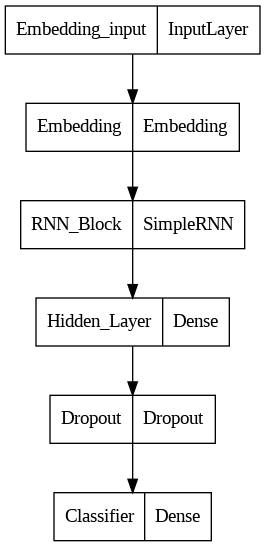

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)

metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('rnn_model_best.h5', save_best_only=True)
]

In [21]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 19s - loss: 0.8639 - accuracy: 0.6258 - recall: 0.4846 - precision: 0.7005 - val_loss: 0.8075 - val_accuracy: 0.6378 - val_recall: 0.5802 - val_precision: 0.6970 - 19s/epoch - 54ms/step
Epoch 2/20
347/347 - 12s - loss: 0.6657 - accuracy: 0.7135 - recall: 0.6232 - precision: 0.7876 - val_loss: 0.8367 - val_accuracy: 0.6332 - val_recall: 0.5294 - val_precision: 0.7103 - 12s/epoch - 35ms/step
Epoch 3/20
347/347 - 11s - loss: 0.4503 - accuracy: 0.8286 - recall: 0.7964 - precision: 0.8533 - val_loss: 0.8926 - val_accuracy: 0.6223 - val_recall: 0.5741 - val_precision: 0.6671 - 11s/epoch - 32ms/step
Epoch 4/20
347/347 - 12s - loss: 0.2974 - accuracy: 0.8946 - recall: 0.8807 - precision: 0.9101 - val_loss: 1.1193 - val_accuracy: 0.6123 - val_recall: 0.5870 - val_precision: 0.6241 - 12s/epoch - 35ms/step
Epoch 5/20
347/347 - 12s - loss: 0.2312 - accuracy: 0.9176 - recall: 0.9050 - precision: 0.9339 - val_loss: 1.2644 - val_accuracy: 0.6177 - val_recall: 0.5950 - val_precisi

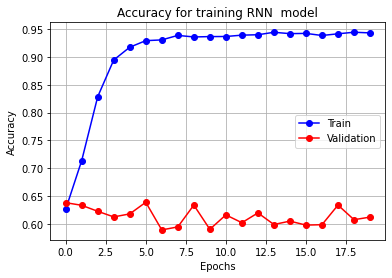

In [22]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-accuracy.png")

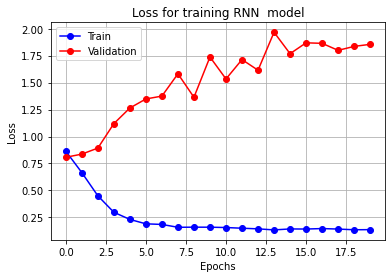

In [23]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-loss.png")

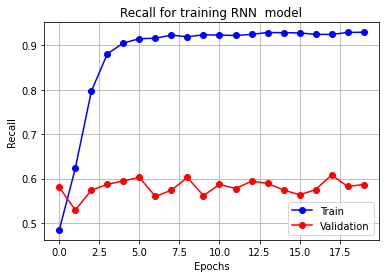

In [24]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-recall.png")

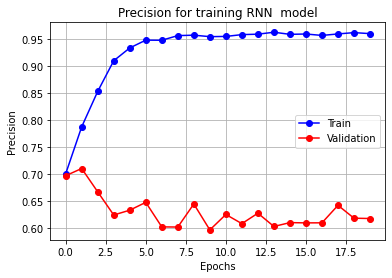

In [25]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-precision.png")

In [26]:
model = keras.models.load_model('/content/rnn_model_best.h5')
model.evaluate(test_padded, test_label)

1/1 [==============================] - 0s 371ms/step - loss: 1.0531 - accuracy: 0.5000 - recall: 0.4000 - precision: 0.6154


[1.053125262260437, 0.5, 0.4000000059604645, 0.6153846383094788]

###LSTM
---

In [27]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.LSTM(64, dropout=0.2, name="LSTM_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 LSTM_Block (LSTM)           (None, 64)                24832     
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,042,211
Trainable params: 1,042,211
Non-trainable params: 0
_________________________________________________________________


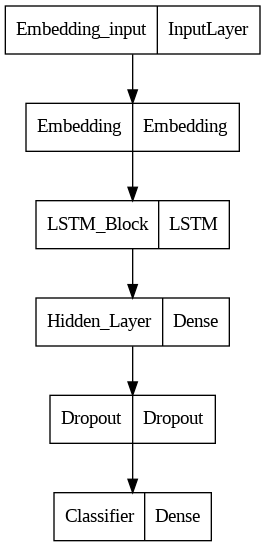

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('lstm_model_best.h5', save_best_only=True)
]

In [30]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 7s - loss: 0.8653 - accuracy: 0.6276 - recall: 0.5108 - precision: 0.6833 - val_loss: 0.8032 - val_accuracy: 0.6447 - val_recall: 0.4793 - val_precision: 0.7870 - 7s/epoch - 21ms/step
Epoch 2/20
347/347 - 3s - loss: 0.6797 - accuracy: 0.7085 - recall: 0.5940 - precision: 0.7954 - val_loss: 0.7521 - val_accuracy: 0.6724 - val_recall: 0.5690 - val_precision: 0.7515 - 3s/epoch - 7ms/step
Epoch 3/20
347/347 - 2s - loss: 0.5457 - accuracy: 0.7824 - recall: 0.7364 - precision: 0.8205 - val_loss: 0.8195 - val_accuracy: 0.6688 - val_recall: 0.6436 - val_precision: 0.6977 - 2s/epoch - 6ms/step
Epoch 4/20
347/347 - 2s - loss: 0.4279 - accuracy: 0.8390 - recall: 0.8123 - precision: 0.8661 - val_loss: 0.8615 - val_accuracy: 0.6695 - val_recall: 0.6389 - val_precision: 0.6967 - 2s/epoch - 6ms/step
Epoch 5/20
347/347 - 2s - loss: 0.3368 - accuracy: 0.8791 - recall: 0.8595 - precision: 0.8984 - val_loss: 1.0168 - val_accuracy: 0.6652 - val_recall: 0.6404 - val_precision: 0.6767 -

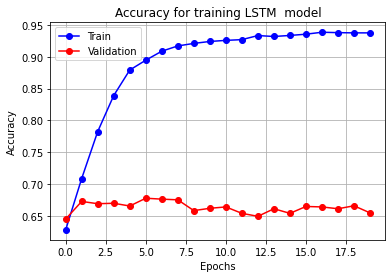

In [31]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-accuracy.png")

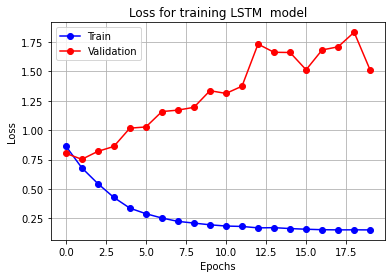

In [32]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-loss.png")

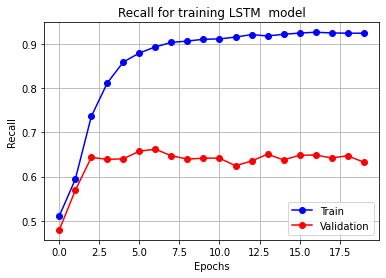

In [33]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-recall.png")

In [ ]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-precision.png")

In [35]:
model = keras.models.load_model('/content/lstm_model_best.h5')
model.evaluate(test_padded, test_label)

1/1 [==============================] - 1s 535ms/step - loss: 1.1746 - accuracy: 0.3500 - recall: 0.3500 - precision: 0.4118


[1.174559235572815, 0.3499999940395355, 0.3499999940395355, 0.4117647111415863]

##Bidirectional LSTM
---

In [36]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, name="Bi_LSTM_Block")))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 Hidden_Layer (Dense)        (None, 64)                8256      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,071,139
Trainable params: 1,071,139
Non-trainable params: 0
____________________________________________

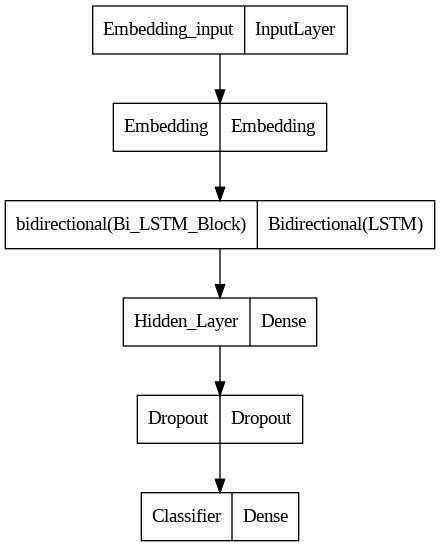

In [37]:
tf.keras.utils.plot_model(model)

In [38]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('bilstm_model_best.h5', save_best_only=True)
]

In [39]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 8s - loss: 0.8356 - accuracy: 0.6388 - recall: 0.5146 - precision: 0.7049 - val_loss: 0.7517 - val_accuracy: 0.6750 - val_recall: 0.5571 - val_precision: 0.7578 - 8s/epoch - 23ms/step
Epoch 2/20
347/347 - 3s - loss: 0.6216 - accuracy: 0.7457 - recall: 0.6831 - precision: 0.7926 - val_loss: 0.7252 - val_accuracy: 0.6987 - val_recall: 0.6519 - val_precision: 0.7318 - 3s/epoch - 10ms/step
Epoch 3/20
347/347 - 3s - loss: 0.4632 - accuracy: 0.8199 - recall: 0.7949 - precision: 0.8416 - val_loss: 0.8138 - val_accuracy: 0.6876 - val_recall: 0.6681 - val_precision: 0.7041 - 3s/epoch - 9ms/step
Epoch 4/20
347/347 - 3s - loss: 0.3470 - accuracy: 0.8708 - recall: 0.8541 - precision: 0.8859 - val_loss: 0.8799 - val_accuracy: 0.6804 - val_recall: 0.6505 - val_precision: 0.6932 - 3s/epoch - 9ms/step
Epoch 5/20
347/347 - 3s - loss: 0.2824 - accuracy: 0.8928 - recall: 0.8800 - precision: 0.9093 - val_loss: 0.9653 - val_accuracy: 0.6674 - val_recall: 0.6465 - val_precision: 0.6842 

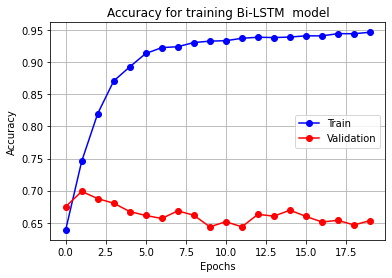

In [40]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-accuracy.png")

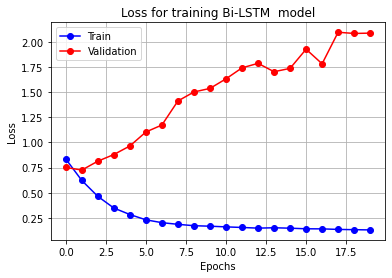

In [41]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-loss.png")

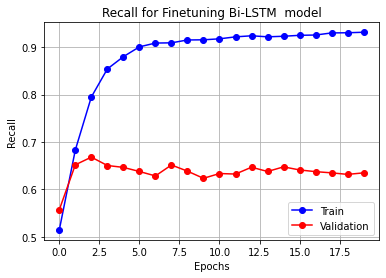

In [42]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for Finetuning Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-recall.png")

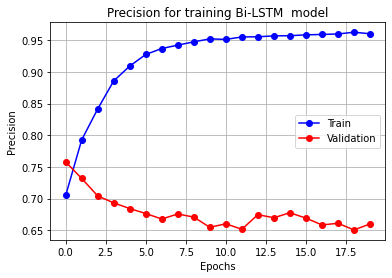

In [43]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-precision.png")

In [44]:
model = keras.models.load_model("/content/bilstm_model_best.h5")
model.evaluate(test_padded, test_label)

1/1 [==============================] - 1s 1s/step - loss: 1.1458 - accuracy: 0.3500 - recall: 0.2500 - precision: 0.3571


[1.1457576751708984, 0.3499999940395355, 0.25, 0.3571428656578064]